## Import/Package Handling


---



In [1]:
!lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   2
  On-line CPU(s) list:    0,1
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.00GHz
    CPU family:           6
    Model:                85
    Thread(s) per core:   2
    Core(s) per socket:   1
    Socket(s):            1
    Stepping:             3
    BogoMIPS:             4000.38
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 cl
                          flush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc re
                          p_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3
                           fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand
                           hypervisor lahf_lm abm 3dnowprefetch i

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [3]:
!nvidia-smi

Thu Dec  5 21:33:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [5]:
!pip install cuml-cu12 cugraph-cu12


In [6]:
import numpy as np
import cudf
import cugraph as cg
import cupy as cp
from cuml.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import pynvml
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE
import time


## Auxillary Functions


---



In [7]:
def print_memory_usage(start_message=None, end_message=None):
    try:
        if start_message is not None:
          print(f"{start_message}")
        # Initialize NVML
        pynvml.nvmlInit()

        # Get handle for the first GPU
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)

        # Get memory info
        info = pynvml.nvmlDeviceGetMemoryInfo(handle)

        print(f"Used GPU memory: {info.used / 1e9:.2f}/{info.total / 1e9:.2f} GB")

        if end_message is not None:
          print(f"{end_message}")

    except pynvml.NVMLError as error:
        print(f"Error querying GPU memory: {error}")

    finally:
        # Always shut down NVML
        try:
            pynvml.nvmlShutdown()
        except pynvml.NVMLError:
            pass


In [8]:
def track_time_and_memory(func):
    def wrapper(*args, **kwargs):
        start_time = time.process_time()
        result = func(*args, **kwargs)
        end_time = time.process_time()
        print(f"{func.__name__} time: {end_time - start_time:.2f}s")
        print_memory_usage(end_message="")
        return result
    return wrapper

## Clustering Code


---



In [9]:
@track_time_and_memory
def normalize_data(data):
    return (data - np.mean(data, axis=0)) / np.std(data, axis=0)

In [10]:
@track_time_and_memory
def build_knn_graph(data, mode = 'jaccard', n_neighbors=15):
    nn = NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(data)
    if mode == 'jaccard':
        knn_graph = nn.kneighbors_graph(data, mode='distance')

        return knn_graph
    elif mode in ('affine', 'gaussian'):
      distances, indices = nn.kneighbors(data)

      return distances, indices
    else:
      raise ValueError("Invalid mode. Choose 'jaccard', 'affine', or 'gaussian'.")

In [11]:
@track_time_and_memory
def run_leiden(graph, resolution=1.0):
    partition, modularity = cg.leiden(graph, resolution=resolution)

    labels = partition['partition'].to_numpy()

    return labels, modularity

### **Affine Clustering Code**


---



In [12]:
@track_time_and_memory
def build_affinity_matrix(indices, distances):
    n_samples = distances.shape[0]
    row_idx = cp.repeat(cp.arange(n_samples), indices.shape[1])
    col_idx = indices.flatten()
    data = cp.exp(-distances.flatten())
    affinity_matrix = cp.sparse.coo_matrix((data, (row_idx, col_idx)), shape=(n_samples, n_samples))
    return affinity_matrix

In [13]:
@track_time_and_memory
def affinity_to_graph(affinity_matrix):
    sparse_matrix = affinity_matrix.get()

    coo_matrix = sparse_matrix.tocoo()

    graph = cg.Graph()
    graph.from_cudf_edgelist(
        cudf.DataFrame({'src': coo_matrix.row, 'dst': coo_matrix.col}),
        source='src',
        destination='dst'
    )

    return graph

### **Jaccard Clustering Code**


---



In [14]:
@track_time_and_memory
def knn_to_graph(knn_graph):
    knn_graph_coo = knn_graph.tocoo()

    row, col, data = knn_graph_coo.row, knn_graph_coo.col, knn_graph_coo.data

    graph = cg.Graph()
    graph.from_cudf_edgelist(
        cudf.DataFrame({'src': row, 'dst': col}),
        source='src',
        destination='dst'
    )

    return graph

In [15]:
@track_time_and_memory
def compute_jaccard(graph):
    edge_list = graph.view_edge_list()

    jaccard_df = cg.jaccard(graph, vertex_pair = edge_list)

    jaccard_graph = cg.Graph()
    jaccard_graph.from_cudf_edgelist(jaccard_df, source='first', destination='second', edge_attr='jaccard_coeff')

    return jaccard_graph

### **Gaussian Clustering Code (not done)**


---



In [16]:
@track_time_and_memory
def gaussian_kernel(distances, indices):
    # Calculate Gaussian kernel similarity on GPU
    sigma = cp.median(distances)  # Use median distance as bandwidth
    similarity = cp.exp(-distances**2 / (2 * sigma**2))

    # Create a sparse graph (using cuGraph)
    n_samples = distances.shape[0]
    row_idx = cp.repeat(cp.arange(n_samples), distances.shape[1])
    col_idx = indices.flatten()
    weights = similarity.flatten()

    # Construct the graph using cugraph
    edgelist_df = cudf.DataFrame({'src': row_idx, 'dst': col_idx, 'weights': weights})
    gaussian_graph = cg.Graph()
    gaussian_graph.from_cudf_edgelist(edgelist_df, source='src', destination='dst', edge_attr='weights')

    return gaussian_graph


## Invoke Functions In Order to Cluster (`main`)


---



In [17]:
def phenograph_clustering_jaccard(data, n_neighbors=15, resolution=1.0):
    start_total = time.process_time()

    # Normalize data
    data = cp.asarray(normalize_data(data))

    # Build k-NN graph (jaccard)
    knn_graph = build_knn_graph(data, mode = 'jaccard', n_neighbors = n_neighbors)

    graph = knn_to_graph(knn_graph)

    # create jaccard similarity graph
    graph = compute_jaccard(graph)

    # Run leiden to get labels
    labels, modularity = run_leiden(graph, resolution)

    end_total = time.process_time()
    print(f"Total time: {end_total - start_total:.2f}s")

    return labels, modularity

In [18]:
def phenograph_clustering_affine(data, n_neighbors=15, resolution=1.0):
    # Normalize data
    start_total = time.process_time()

    data = cp.asarray(normalize_data(data))

    # Build k-NN graph (affine)
    distances, indices = build_knn_graph(data, mode = 'affine', n_neighbors = n_neighbors)

    # Create affinity matrix
    affinity_matrix = build_affinity_matrix(indices, distances)

    # Convert to affinity graph
    graph = affinity_to_graph(affinity_matrix)

    # Run leiden to get labels
    labels, modularity = run_leiden(graph, resolution)

    end_total = time.process_time()
    print(f"Total time: {end_total - start_total:.2f}s")

    return labels, modularity

In [19]:
def phenograph_clustering_gaussian(data, n_neighbors=15, resolution=1.0):
    # Normalize data
    start_total = time.process_time()

    data = cp.asarray(normalize_data(data))

    # Build k-NN graph (affine)
    distances, indices = build_knn_graph(data, mode = 'affine', n_neighbors = n_neighbors)

    # Create gaussian similarity graph
    graph = gaussian_kernel(distances, indices)

    # Run leiden to get labels
    labels, modularity = run_leiden(graph, resolution)

    end_total = time.process_time()
    print(f"Total time: {end_total - start_total:.2f}s")

    return labels, modularity

## Testing


---



In [20]:
X, _ = make_blobs(n_samples=1000000, n_features = 20, centers=5, random_state=42)

cluster_labels, modularity = phenograph_clustering_jaccard(X, n_neighbors=100, resolution=0.001)
print(len(set(cluster_labels)))
print(modularity)

normalize_data time: 0.41s
Used GPU memory: 0.27/16.11 GB

build_knn_graph time: 97.05s
Used GPU memory: 1.43/16.11 GB

knn_to_graph time: 2.40s
Used GPU memory: 2.39/16.11 GB

compute_jaccard time: 10.87s
Used GPU memory: 4.61/16.11 GB

run_leiden time: 17.04s
Used GPU memory: 2.77/16.11 GB

Total time: 128.19s
30048
0.982593297958374


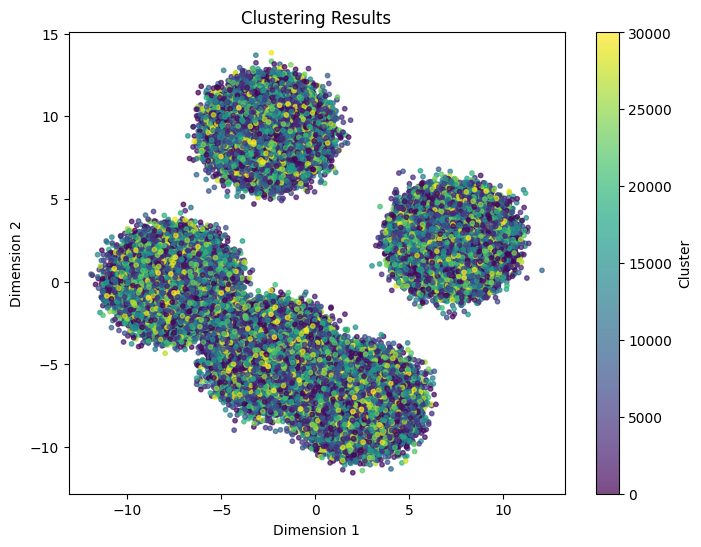

In [23]:
# X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10, random_state=42).fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, s=10, cmap='viridis', alpha=0.7)
plt.title("Clustering Results")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(label="Cluster")
plt.show()

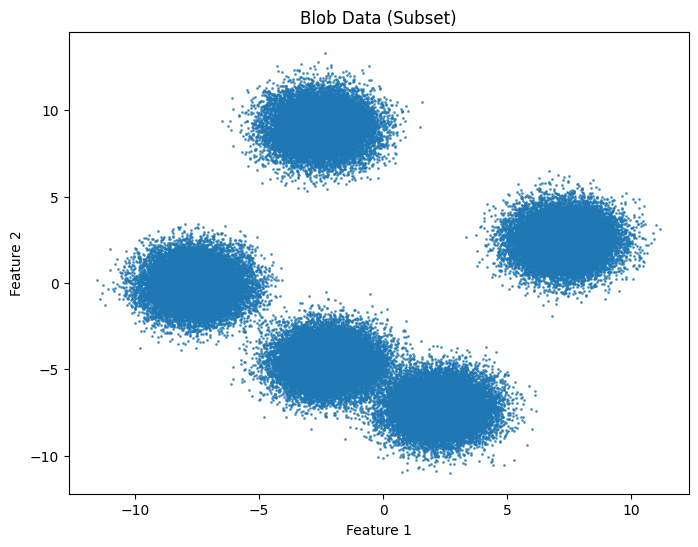

In [22]:
X, _ = make_blobs(n_samples=1000000, centers=5, n_features = 20, random_state=42)

subset = np.random.choice(len(X), size=100000, replace=False)
X_subset = X[subset]

plt.figure(figsize=(8, 6))
plt.scatter(X_subset[:, 0], X_subset[:, 1], s=1, alpha=0.7)
plt.title("Blob Data (Subset)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()